# Demonstration of pyQ3 python wrapper for DEW-ENKI-EQ3 aqueous speciation calculations - TUTORIAL 2

First import the required packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyQ3
from copy import copy

## Calculate speciation for a fluid with defined molalities
In the previous notebook it was demonstrated how the DATA0 database file can be constructed for use with manual EQ3 calculations. The pyQ3 module also provides a python interface to these calculations. To demonstrate this we will use the default system. To create a customised system, see the first tutorial.

Create a DEW System:

In [2]:
dew_system = pyQ3.System()

### Speciation without specifying pH or fO2:
The pH of a solution can be calculated by charge balance if all other chemical components are constrained. Some solutions will be insensitive to fO2, so we will also skip this to start with.

We must specify the molality of elements present in the solution, in terms of their basis species. Let's check what the basis species are:

In [3]:
print(dew_system.basis_species_names)

['H2O', 'H+', 'AG+', 'AL+3', 'AU+', 'BA+2', 'CA+2', 'CO2(AQ)', 'H4SIO4(AQ)', 'CL-', 'SO4-2', 'CD+2', 'N2(AQ)', 'CR+2', 'CS+', 'CU+', 'EU+2', 'F-', 'FE+2', 'H3PO4(AQ)', 'HG+2', 'K+', 'MG+2', 'MN+2', 'NA+', 'PB+2', 'SR+2', 'U+4', 'ZN+2', 'O2']


In [4]:
molalities = {'NA+': 0.1,
              'CL-': 0.1,
              'H4SIO4(AQ)':0.5}

We need to choose a temperature and pressure to run the calculation at:

In [5]:
T = 500.0 + 273.15 # in K
P = 8500.0 # in bar

Now we can generate the fluid:

In [6]:
dew_fluid = pyQ3.Fluid(dew_system, T, P, molalities=molalities)

When we created the dew_fluid object several things happened in the background:
1. a DATA0 file covering the pressure and temperature of the fluid was generated
2. The EQPT processor was run to generate the data1 file from DATA0
3. An EQ3 input file was generated using the constraints we set
4. EQ3 was run to do the speciation calculation
5. The EQ3 output file was read in

We can now look up different properties of the fluid, for example the speciation:

In [7]:
dew_fluid.aqueous_species

,species,molality,log_g,activity
0,H4SIO4(AQ),2.347172e-01,0.0000,2.347000e-01
1,H6SI2O7(AQ),1.323791e-01,0.0000,1.324000e-01
2,NA+,9.578317e-02,-0.1556,6.694000e-02
3,CL-,9.566903e-02,-0.1556,6.686000e-02
4,NACL(AQ),4.200542e-03,0.0000,4.201000e-03
5,H8SI3O10(AQ),1.312946e-04,0.0000,1.313000e-04
6,H3SIO4-,1.307279e-04,-0.1556,9.136000e-05
7,HCL(AQ),1.304248e-04,0.0000,1.304000e-04
8,H+,1.206938e-04,-0.1556,8.435000e-05
9,OH-,1.041005e-04,-0.1556,7.275000e-05


We could check that the input molalities were read correctly by checking the elemental molalities:

In [8]:
dew_fluid.elemental_comp

,element,ppm,molality
0,O,917984.1388,.5737616028E+02
1,H,113643.0641,.1127523208E+03
2,SI,14042.7500,.5000000000E+00
3,CL,3545.3000,.1000000000E+00
4,NA,2298.9770,.1000000000E+00


Since the pH will be calculated by charge balance if we don't explicitly set it, we can check the pH:

In [9]:
dew_fluid.pH

4.0739

What about fO2?

In [10]:
dew_fluid.fO2

-12.6

But we didn't set fO2, nor is it constrained by the calculation! Well, actually the code sets it to an abitrary value of -12.6.

Would this fluid crystallise? We can check:

In [11]:
dew_fluid.mineral_saturation

,mineral,log_q_k,aff,state
0,QUARTZ,0.447,1.582,ssatd
1,COESITE,0.156,0.552,ssatd


Unsurprisingly, yes!


### Redox sensitive equilibria- specified fO2
Most natural chemical systems will be sensitive to fO2. We may want to do calculations at a specified fO2, and we can run many calculations to explore the effect of fO2. Here I will demonstrate this with a system involving Fe.

Let's set up the fluid composition:

In [12]:
molalities = {'FE+2':0.001}
T = 500.0 + 273.15 # in K
P = 17000.0 # in bar

And we can run the calculations over a range of log(fO2):

In [13]:
fO2 = np.linspace(-30,-5,12)

This means we need to run the calculations with a loop and store the results:

In [14]:
results = []
for i in range(len(fO2)):
    dew_fluid = pyQ3.Fluid(dew_system,T,P,molalities=molalities,fO2=fO2[i])
    results.append(dew_fluid)

Let's make a plot of iron speciation:

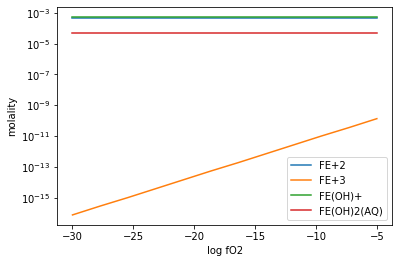

In [15]:
species_to_plot = ['FE+2','FE+3','FE(OH)+','FE(OH)2(AQ)']

# Initiate the plot
f,a = plt.subplots()

for sp in species_to_plot:
    mol = []
    for i in range(len(fO2)):
        mol.append(float(results[i].aqueous_species[results[i].aqueous_species.species==sp].molality))
    a.plot(fO2,mol,label=sp)

a.set_yscale('log')

a.set_xlabel('log fO2')
a.set_ylabel('molality')
    
a.legend()
plt.show()

In Tutorial 3 we will set the fO2 by mineral equilibrium.

## Controlling the pH

Perhaps we want to calculate speciation at a specified pH. Usually the pH is set by charge balance, so we will need to tell the code what to use in its place to ensure charge balance.

In [16]:
molalities = {'NA+':0.1,
              'CL-': 0.1,
              'H4SIO4(AQ)':0.5}
T = 500.0 + 273.15 # in K
P = 8500.0 # in bar

Just like in the previous example we can run it over a range of pH, and see what happens for the speciation:

In [17]:
pH = np.linspace(2.0,8.0,20)

In [18]:
results = []
for i in range(len(pH)):
    dew_fluid = pyQ3.Fluid(dew_system,T,P,molalities=molalities,pH=pH[i],uebal='NA+')
    results.append(dew_fluid)

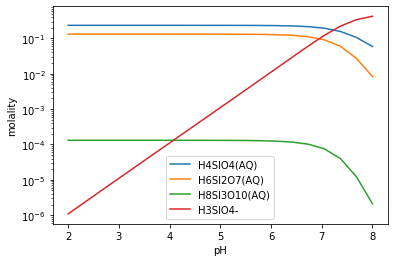

In [19]:
species_to_plot = ['H4SIO4(AQ)','H6SI2O7(AQ)','H8SI3O10(AQ)','H3SIO4-']

# Initiate the plot
f,a = plt.subplots()

for sp in species_to_plot:
    mol = []
    for i in range(len(pH)):
        mol.append(float(results[i].aqueous_species[results[i].aqueous_species.species==sp].molality))
    a.plot(pH,mol,label=sp)

a.set_yscale('log')

a.set_xlabel('pH')
a.set_ylabel('molality')
    
a.legend()
plt.show()

**NOTE: You can save the figures using the command f.save_fig('filename.ext') where ext is the extension for the format you want, e.g. png, pdf, or svg. You can also change all sorts of things with the plots- look up the matplotlib documentation for more info**